In [70]:
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score
from scipy.stats import norm
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
POSTGRES = {

'user' : 'postgres',
'pw' : 'admin',
'host' : 'localhost',
'port' : '5432',
'db' : 'options'
}

In [14]:
class Config(object):
    # ...
    SQLALCHEMY_DATABASE_URI =  os.environ.get('DATABASE_URL') or 'postgresql://%(user)s:%(pw)s@%(host)s:%(port)s/%(db)s' % POSTGRES
    SQLALCHEMY_TRACK_MODIFICATIONS = False

config = Config()

cnx = create_engine(config.SQLALCHEMY_DATABASE_URI)

In [15]:
df = pd.read_sql_query("select * from chains", cnx)

In [16]:
df['short_asof_date'] = df['asof_date'].apply(lambda x: x.date().strftime('%Y-%m-%d'))

In [17]:
dfLastDate = df[df['short_asof_date'] == df['short_asof_date'].iloc[-1]]

In [18]:
dfLastDate.expiry.unique()

array(['2021-12-31T00:00:00.000000000', '2022-01-03T00:00:00.000000000',
       '2022-01-05T00:00:00.000000000', '2022-01-07T00:00:00.000000000',
       '2022-01-10T00:00:00.000000000', '2022-01-12T00:00:00.000000000',
       '2022-01-14T00:00:00.000000000', '2022-01-18T00:00:00.000000000',
       '2022-01-19T00:00:00.000000000', '2022-01-21T00:00:00.000000000',
       '2022-01-24T00:00:00.000000000', '2022-01-26T00:00:00.000000000',
       '2022-01-28T00:00:00.000000000', '2022-01-31T00:00:00.000000000',
       '2022-02-02T00:00:00.000000000', '2022-02-04T00:00:00.000000000',
       '2022-02-07T00:00:00.000000000', '2022-02-11T00:00:00.000000000',
       '2022-02-18T00:00:00.000000000', '2022-03-18T00:00:00.000000000',
       '2022-03-31T00:00:00.000000000', '2022-04-14T00:00:00.000000000',
       '2022-05-20T00:00:00.000000000', '2022-06-17T00:00:00.000000000',
       '2022-06-30T00:00:00.000000000', '2022-09-16T00:00:00.000000000',
       '2022-09-30T00:00:00.000000000', '2022-12-16

<AxesSubplot:xlabel='expiry'>

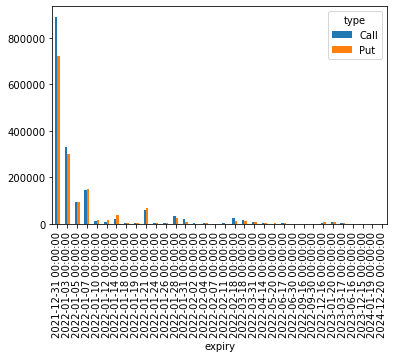

In [162]:
volumeByExpiry = dfLastDate.groupby(['expiry', 'type']).sum()['volume'].unstack()
volumeByExpiry.plot(kind='bar')

In [19]:
calls = dfLastDate[dfLastDate['type'] == 'Call']
puts = dfLastDate[dfLastDate['type'] == 'Put']

In [20]:
expiry = '2022-01-03'
calls_expiry = calls[calls['expiry']==expiry]

In [21]:
calls_expiry

,asof_date,strike,last,theor,delta,gamma,iv,theta,vega,rho,vol_oi,volume,open_int,type,last_trade,expiry,last_px_underlying,short_asof_date
78,2022-01-01 19:11:33,455.0,21.03,20.40,0.92643,0.00985,0.3304,-0.32102,0.05999,0.02402,0.02,15,806,Call,2021-12-31,2022-01-03,474.96,2022-01-01
79,2022-01-01 19:11:33,457.0,19.52,18.41,0.92000,0.01134,0.3059,-0.31663,0.06393,0.02414,0.04,48,1317,Call,2021-12-31,2022-01-03,474.96,2022-01-01
80,2022-01-01 19:11:33,458.0,18.49,17.41,0.91750,0.01216,0.2919,-0.30910,0.06543,0.02403,0.01,17,1296,Call,2021-12-31,2022-01-03,474.96,2022-01-01
81,2022-01-01 19:11:33,459.0,17.13,16.42,0.91303,0.01341,0.2801,-0.30855,0.06807,0.02414,0.17,88,513,Call,2021-12-31,2022-01-03,474.96,2022-01-01
82,2022-01-01 19:11:33,460.0,16.10,15.43,0.90876,0.01431,0.2674,-0.30516,0.07055,0.02419,0.04,152,3930,Call,2021-12-31,2022-01-03,474.96,2022-01-01
83,2022-01-01 19:11:33,461.0,15.07,14.42,0.90584,0.01552,0.2525,-0.29459,0.07221,0.02423,0.01,8,775,Call,2021-12-31,2022-01-03,474.96,2022-01-01
84,2022-01-01 19:11:33,462.0,14.54,13.42,0.90071,0.01701,0.2395,-0.29045,0.07508,0.02427,0.03,48,1869,Call,2021-12-31,2022-01-03,474.96,2022-01-01
85,2022-01-01 19:11:33,463.0,12.17,12.42,0.89562,0.01942,0.2257,-0.28363,0.07786,0.02429,0.03,55,1861,Call,2021-12-31,2022-01-03,474.96,2022-01-01
86,2022-01-01 19:11:33,464.0,11.03,11.43,0.88790,0.02082,0.2136,-0.28255,0.08198,0.02441,0.02,44,2180,Call,2021-12-31,2022-01-03,474.96,2022-01-01
87,2022-01-01 19:11:33,465.0,10.30,10.44,0.88060,0.02326,0.2000,-0.27646,0.08573,0.02440,0.05,220,4447,Call,2021-12-31,2022-01-03,474.96,2022-01-01


In [22]:
print(calls_expiry['volume'].mean(),calls_expiry['volume'].std()) 

8411.384615384615 17066.575025031245


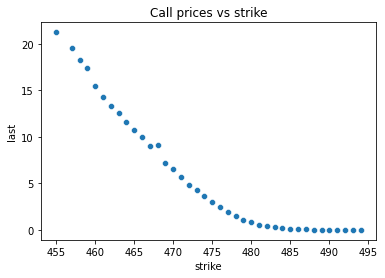

In [62]:
sns.scatterplot(data=calls_expiry, x='strike', y='last')
plt.title('Call prices vs strike')
plt.show()

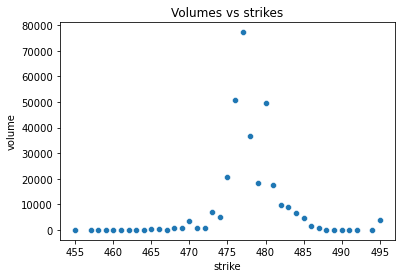

In [28]:
sns.scatterplot(data=calls_expiry, x='strike', y='volume')
plt.title('Volumes vs strikes')
plt.show()

### Butterfly approximation approach

https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

In [40]:
calls['expiry'].unique()

array(['2021-12-31T00:00:00.000000000', '2022-01-03T00:00:00.000000000',
       '2022-01-05T00:00:00.000000000', '2022-01-07T00:00:00.000000000',
       '2022-01-10T00:00:00.000000000', '2022-01-12T00:00:00.000000000',
       '2022-01-14T00:00:00.000000000', '2022-01-18T00:00:00.000000000',
       '2022-01-19T00:00:00.000000000', '2022-01-21T00:00:00.000000000',
       '2022-01-24T00:00:00.000000000', '2022-01-26T00:00:00.000000000',
       '2022-01-28T00:00:00.000000000', '2022-01-31T00:00:00.000000000',
       '2022-02-02T00:00:00.000000000', '2022-02-04T00:00:00.000000000',
       '2022-02-07T00:00:00.000000000', '2022-02-11T00:00:00.000000000',
       '2022-02-18T00:00:00.000000000', '2022-03-18T00:00:00.000000000',
       '2022-03-31T00:00:00.000000000', '2022-04-14T00:00:00.000000000',
       '2022-05-20T00:00:00.000000000', '2022-06-17T00:00:00.000000000',
       '2022-06-30T00:00:00.000000000', '2022-09-16T00:00:00.000000000',
       '2022-09-30T00:00:00.000000000', '2022-12-16

In [54]:
calls.groupby('expiry').sum()['volume']

expiry
2021-12-31    891527
2022-01-03    328044
2022-01-05     91747
2022-01-07    145410
2022-01-10     11581
2022-01-12      6504
2022-01-14     21556
2022-01-18      4170
2022-01-19      1807
2022-01-21     56869
2022-01-24      2472
2022-01-26      1416
2022-01-28     33015
2022-01-31     18483
2022-02-02       827
2022-02-04      2763
2022-02-07       101
2022-02-11      1453
2022-02-18     24586
2022-03-18     13777
2022-03-31      7345
2022-04-14      1650
2022-05-20       264
2022-06-17      1245
2022-06-30       260
2022-09-16        43
2022-09-30        13
2022-12-16      4310
2023-01-20      5451
2023-03-17      1757
2023-06-16        66
2023-12-15        69
2024-01-19       159
2024-12-20        82
Name: volume, dtype: int64

In [55]:
expiry = '2022-01-07'
calls_expiry = calls[calls['expiry']==expiry]

In [56]:
butterfly = calls_expiry[['strike', 'last', 'volume']].copy(deep=True)

In [59]:
butterfly['bfPrice'] = butterfly['last'].shift(1) - 2 * butterfly['last'] + butterfly['last'].shift(-1)

In [60]:
butterfly

,strike,last,volume,bfPrice
234,455.0,21.26,15,NaN
235,457.0,19.53,38,4.600000e-01
236,458.0,18.26,15,4.600000e-01
237,459.0,17.45,405,-1.180000e+00
238,460.0,15.46,134,8.600000e-01
239,461.0,14.33,182,1.200000e-01
240,462.0,13.32,58,2.400000e-01
241,463.0,12.55,259,-1.200000e-01
242,464.0,11.66,209,-7.000000e-02
243,465.0,10.70,92,2.900000e-01


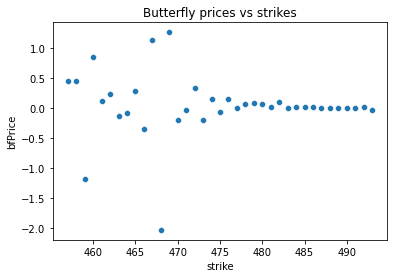

In [61]:
sns.scatterplot(data=butterfly, x='strike', y='bfPrice')
plt.title('Butterfly prices vs strikes')
plt.show()

### Breeden-Lintzenberger

In [64]:
def BSPrice(S, K, r, T, vol):
    
    d1 = (np.log(S/K) + (r + 0.5* vol)*T)/(vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    
    BS = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return BS

In [141]:
expiry_in_days = calls_expiry['expiry'].iloc[20] - calls_expiry['asof_date'].iloc[20]
yearFrac = expiry_in_days.total_seconds() / (60*60*24*256)

In [111]:
calls_expiry.iloc[20,:]

asof_date             2022-01-01 19:12:09
strike                                476
last                                 2.44
theor                                2.48
delta                             0.44391
gamma                             0.05248
iv                                 0.1146
theta                            -0.20705
vega                              0.25971
rho                               0.03503
vol_oi                                  5
volume                              24065
open_int                             4812
type                                 Call
last_trade            2021-12-31 00:00:00
expiry                2022-01-07 00:00:00
last_px_underlying                 474.96
short_asof_date                2022-01-01
Name: 254, dtype: object

In [144]:
BSPrice(calls_expiry['last_px_underlying'].iloc[20], calls_expiry['strike'].iloc[20], 0.0006, yearFrac, 0.1146)


2.602301106681921

In [142]:
yearFrac

0.020312093098958334

In [122]:
import os

In [164]:
filename = 'DTB3.xls'

path = os.getcwd() + '\\' + filename

rf = pd.read_excel(filename)
rf['DTB3'] = rf['DTB3']/100
rf = rf.rename(columns={'observation_date':'asof_date', 'DTB3':'rfr'})

In [165]:
calls_expiry = pd.merge(left=calls_expiry, right=rf, how='left', left_on='short_asof_date', right_on='asof_date')